In [3]:
import math
import operator
from pathlib import Path

from ipywidgets import fixed, interact
import ipywidgets as widgets
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import describe, gaussian_kde
import seaborn as sns

import sys
sys.path.insert(0, '../../utils')




mated_colour = "green"
mated_label = "Mated scores"
nonmated_colour = "red"
nonmated_label = "Non-mated scores"

figure_size = (12,6)
alpha_shade = 0.25
alpha_fill = 1.0
linewidth = 2
legend_loc = "upper left"
legend_anchor = (1.0, 1.02)
legend_cols = 1
legend_fontsize = 12
label_fontsize = 16

threshold_colour = "black"
threshold_style = "--"
round_digits = 5
sns.set(style="white", palette="muted", color_codes=True)
plt.rc("axes", axisbelow=True)

# load utils
import sys
sys.path.insert(0, '../utils')
from Model_utils.MagFace_funcs_1 import *

# Convert child ids to real ids as in child_balanced.

# For all Ids, get last id name and convert to unique ids
def convert_unique_ids(ids):
    unique_ids_list = []
    for id in ids:
        im_name = id.split("/")[-1][:-4]
        if '.' in im_name:
            un_id = im_name[:-5]
        else:
            un_id = "_".join(im_name.split("_")[:-1])

        unique_ids_list.append(un_id)
    return unique_ids_list

# Get unique ids
def factorize_ids(ids):
    unique_ids = {}
    factors = []
    for id in ids:
        if id not in unique_ids:
            unique_ids[id] = len(unique_ids)  # Assign a unique index for each unique ID
        factors.append(unique_ids[id])  # Append the index corresponding to the ID
    return factors, unique_ids


In [4]:
os.getcwd()

'/mnt/c/Dokumenter/Dokumenter/UNI/Master/Thesis/GitHub_Repo/Master_Thesis/notebooks/DET_vis'

In [5]:
path_children_feature_vector = '../../data/data_full/feature_vectors/magface_feature_vectors/feat_img_children_full.list'

path_adults_feature_vector = '../../data/data_full/feature_vectors/magface_feature_vectors/feat_img_adults_full.list'

In [6]:
# load childrens feature vectors and load adults featur vector
with open(path_children_feature_vector, 'r') as f:
    lines = f.readlines()

img_2_feats = {}
img_2_mag = {}
for line in lines:
    parts = line.strip().split(' ')
    imgname = parts[0]
    imgname = "/"+"/".join(imgname.split("/")[4:])
    feats = [float(e) for e in parts[1:]]
    mag = np.linalg.norm(feats)
    img_2_feats[imgname] = feats/mag
    img_2_mag[imgname] = mag #magnitude of the feature vector

imgnames = list(img_2_mag.keys())
mags = [img_2_mag[imgname] for imgname in imgnames]
sort_idx = np.argsort(mags) #sorts the magnitude/quality of the images
feats = np.array([img_2_feats[imgnames[ele]] for ele in range(len(lines))]) #unsorted image quality
ids_c = np.array([imgnames[ele] for ele in range(len(lines))])

sim_mat_c = np.dot(feats, feats.T)
sim_scores_c = sim_mat_c.copy()
plot_sims_c = sim_scores_c[sim_scores_c < 0.9999].reshape(-1)


In [15]:
from Data_proc_utils.Data_proc_funcs import *
random_states = [42]
a_df = pd.read_csv('../../data/image_info_csvs/final_filtered_adults_df_BIBEL.csv')
adults_all = a_df
children_all = pd.read_csv('../../data/image_info_csvs/final_filtered_children_df_BIBEL.csv')
children_balanced_df_1 = balance_child_data(children_all, print_stats=True, random_state=random_states[0])
adults_balanced_df_1 = balance_adults_data_enrolled(children_balanced_df_1, adults_all, print_stats=True, random_state=random_states[0])


minority age group from childrens data:  13-15 
number of images:  642 

racial distribution: ethnicity
Indian       176
African      169
Caucasian    158
Asian        139
Name: image_name, dtype: int64 

All new groups should have same distribution

Other age group stats: 
0-3
 Series([], Name: image_name, dtype: int64)

16-18 Series([], Name: image_name, dtype: int64)
Balanced data?: 13-15    642
1-3      642
4-6      642
7-9      642
10-12    642
Name: children_agegroup, dtype: int64
Balanced data between adults and children?: 

adults:  ethnicity
African      494
Caucasian    494
Indian       444
Asian        411
Name: identity_name, dtype: int64 
number of enrolled, and non-enrolled ids (a):  802 1041 

children:  ethnicity
African      494
Caucasian    494
Indian       444
Asian        411
Name: identity_name, dtype: int64 
number of enrolled, and non-enrolled ids (c):  802 1041
Duplicates? 0
is child ids same as adults ids number non-enrolled? 228 228


In [22]:

# with open(path_adults_feature_vector, 'r') as f:
#     lines = f.readlines()[:10]
#     print(lines)

# img_2_feats = {}
# img_2_mag = {}
# # Convert to dictionary as adaface - is done in img_2_feats
# for line in lines:
#     parts = line.strip().split(' ')
#     imgname = parts[0]
#     imgname = "/"+"/".join(imgname.split("/")[4:])
#     feats = [float(e) for e in parts[1:]]
#     mag = np.linalg.norm(feats)
#     img_2_feats[imgname] = feats/mag
#     img_2_mag[imgname] = mag #magnitude of the feature vector
# imgnames = list(img_2_mag.keys())
# mags = [img_2_mag[imgname] for imgname in imgnames]
# sort_idx = np.argsort(mags) #sorts the magnitude/quality of the images
# feats_a = np.array([img_2_feats[imgnames[ele]] for ele in range(len(lines))]) #unsorted image quality
# ids_a = np.array([imgnames[ele] for ele in range(len(lines))])


# Load the DataFrame containing image names
df = adults_balanced_df_1  # Adjust filename/path as necessary

# Create a set of image names from the DataFrame for fast lookup
image_names_set = set(df['image_name'])  # Adjust 'image_name' to your DataFrame's column name

img_2_feats = {}
img_2_mag = {}

# Open and process the feature vector file
with open(path_adults_feature_vector, 'r') as f:
    for line in f:
        parts = line.strip().split(' ')
        # Extract image name in the desired format
        imgname = parts[0]
        imgname_formatted = "/" + "/".join(imgname.split("/")[4:])
        print(imgname_formatted)

        # Extract the specific image ID from the filename, e.g., 'm.05pnr7_0002' from the path
        image_id = imgname.split('/')[-1].split('.')[0]  # Adjust the splitting logic if necessary
        print(image_id)



        # Check if this image ID is in the set
        if image_id in image_names_set:
            feats = [float(e) for e in parts[1:]]
            mag = np.linalg.norm(feats)
            img_2_feats[imgname_formatted] = feats/mag
            img_2_mag[imgname_formatted] = mag

            break
        break


# Continue processing with the filtered data
imgnames = list(img_2_mag.keys())
mags = [img_2_mag[imgname] for imgname in imgnames]
sort_idx = np.argsort(mags)  # sorts the magnitude/quality of the images
feats_a = np.array([img_2_feats[imgnames[ele]] for ele in range(len(img_2_feats))])  # unsorted image quality
ids_a = np.array(imgnames)

# You can now proceed with further analysis or visualization of feats_a and ids_a


/data/raw_full/adults_full/African_m.05pnr7/m.05pnr7_0003.jpg
m


In [19]:
image_names_set # To check the shape of the array


{'m.027klgs_0001',
 'm.0bf4p4_0001',
 'm.023l4f_0001',
 'm.07vypw_0002',
 'm.0gdkq_b_0002',
 'm.027kskr_0002',
 'm.026sl3m_0001',
 'm.0bvgv4_0003',
 'm.01w724_0003',
 'm.03c2spd_0004',
 'm.027b8b_0001',
 'm.07lwh3_0002',
 'm.04_zbx_0001',
 'm.0h_f946_0001',
 'm.04n2dlf_0005',
 'm.04l0px_0001',
 'm.02qkwbp_0002',
 'm.044bn5_0002',
 'm.0k3_4h_0003',
 'm.01jsz8_0001',
 'm.064qbj5_0001',
 'm.047wv2_0004',
 'm.0801_6_0003',
 'm.04f1wxr_0001',
 'm.0gchc3g_0001',
 'm.01py6c1_0003',
 'm.0k7_34j_0002',
 'm.029yw7_0002',
 'm.0c2qjg_0006',
 'm.03xmw5p_0001',
 'm.028brc9_0001',
 'm.07m81f_0003',
 'm.087tf6_0005',
 'm.07dbmn_0001',
 'm.01lsdlr_0001',
 'm.0c8gr5_0001',
 'm.09v1659_0003',
 'm.0gx2s9n_0001',
 'm.01b_88_0001',
 'm.01wvydk_0002',
 'm.02qnlkc_0004',
 'm.02pkg3_0001',
 'm.046x06_0002',
 'm.07k7m7z_0001',
 'm.0dx1kz_0004',
 'm.03d09qd_0001',
 'm.020sb7_0001',
 'm.07k7m7z_0002',
 'm.066w07_0003',
 'm.0hzpkcs_0004',
 'm.01wtszb_0001',
 'm.0167hz_0002',
 'm.02zrgt_0003',
 'm.03cg0tw_0004',
 '

In [ ]:

sim_mat_a = np.dot(feats_a, feats_a.T)


: 

In [ ]:

ids_a = convert_unique_ids(ids_a)


In [ ]:

factors_a, unique_ids = factorize_ids(ids_a)


In [ ]:


sim_scores_a = sim_mat_a.copy()
plot_sims_a = sim_scores_a[sim_scores_a < 0.999].reshape(-1)


In [14]:

# Mated and non-mated ids
a_df = pd.read_csv('../../data/image_info_csvs/final_filtered_adults_df_BIBEL.csv')
c_df = pd.read_csv('../../data/image_info_csvs/final_filtered_children_df_BIBEL.csv')

df_c_ofiq = pd.read_csv("../../data/OFIQ_results/children_all_final.csv", sep=",")
df_a_ofiq = pd.read_csv("../../data/OFIQ_results/table_adults_all_in_one.csv", sep=",")
df_can_ofiq = pd.read_csv("../../data/OFIQ_results/canonical_children.csv", sep=",")


OFIQ_component = 'UnifiedQualityScore.scalar'

poor_c_ofiq = df_c_ofiq[df_c_ofiq[OFIQ_component] < df_c_ofiq[OFIQ_component].median()]
poor_a_ofiq = df_a_ofiq[df_a_ofiq[OFIQ_component] < df_a_ofiq[OFIQ_component].median()]
poor_can_ofiq = df_can_ofiq[df_can_ofiq[OFIQ_component] > 29]

def extract_identifier(filepath):
    filename = filepath.split('/')[-1]
    parts = filename.split('.')
    if parts[-2].isdigit():
        identifier = '.'.join(parts[-3:-1])
    else:
        identifier = '.'.join(parts[:-1])  # Join everything except the extension
    return identifier

# Apply the function on the DataFrame column
poor_a_ofiq['Identityname'] = poor_a_ofiq['Filename'].apply(extract_identifier)
poor_c_ofiq['Identityname'] = poor_c_ofiq['Filename'].apply(extract_identifier)
poor_can_ofiq['Identityname'] = poor_can_ofiq['Filename'].apply(extract_identifier)


/var/folders/hl/6j_44f453mvc5lr922s8d0l80000gn/T/ipykernel_75808/2924334593.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poor_a_ofiq['Identityname'] = poor_a_ofiq['Filename'].apply(extract_identifier)
/var/folders/hl/6j_44f453mvc5lr922s8d0l80000gn/T/ipykernel_75808/2924334593.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poor_c_ofiq['Identityname'] = poor_c_ofiq['Filename'].apply(extract_identifier)


In [18]:
df_a_ofiq

,Filename,UnifiedQualityScore,BackgroundUniformity,IlluminationUniformity,LuminanceMean,LuminanceVariance,UnderExposurePrevention,OverExposurePrevention,DynamicRange,Sharpness,...,LeftwardCropOfTheFaceImage.scalar,RightwardCropOfTheFaceImage.scalar,DownwardCropOfTheFaceImage.scalar,UpwardCropOfTheFaceImage.scalar,HeadPoseYaw.scalar,HeadPosePitch.scalar,HeadPoseRoll.scalar,ExpressionNeutrality.scalar,NoHeadCoverings.scalar,Unnamed: 57
0,../../../data/tests/images/adults_full_final/m...,22.843954,71.516904,0.499635,0.337319,0.047136,0.198074,0.000000,7.576965,50,...,100,100,58,23,99,99,100,69,0,NaN
1,../../../data/tests/images/adults_full_final/m...,21.374777,37.258586,0.584877,0.221608,0.016571,0.140255,0.000000,6.845002,-11,...,100,100,9,1,100,100,100,36,100,NaN
2,../../../data/tests/images/adults_full_final/m...,21.944078,31.729164,0.332908,0.114954,0.014525,0.558846,0.000000,6.167718,-31,...,100,100,23,7,76,81,97,34,100,NaN
3,../../../data/tests/images/adults_full_final/m...,21.284401,97.060087,0.685185,0.162128,0.020428,0.432749,0.000000,6.572763,-26,...,100,100,94,95,99,76,100,49,100,NaN
4,../../../data/tests/images/adults_full_final/m...,18.683163,64.572584,0.532599,0.343895,0.013737,0.008838,0.000000,6.679960,-14,...,100,100,12,2,100,99,100,51,100,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36437,../../../data/tests/images/adults_full_final/m...,22.174162,198.838779,0.625390,0.302620,0.035789,0.109209,0.000000,7.330758,-24,...,100,100,6,1,91,99,100,12,100,NaN
36438,../../../data/tests/images/adults_full_final/m...,24.823811,168.138308,0.522373,0.293775,0.009479,0.033023,0.000000,6.655987,-41,...,100,100,11,2,89,97,100,13,100,NaN
36439,../../../data/tests/images/adults_full_final/m...,18.592001,66.181583,0.542700,0.705963,0.052286,0.001681,0.153326,6.642255,-34,...,100,100,16,3,90,100,100,57,100,NaN
36440,../../../data/tests/images/adults_full_final/m...,20.047659,34.442842,0.392734,0.258039,0.041665,0.294725,0.000000,7.303942,-9,...,100,100,47,15,89,99,100,68,100,NaN


In [21]:
# Convert file names to ID
def id_class(im_enter):
    if "." in im_enter[:-4]:
        im = im_enter.split("_")[0]
    else:
        im = "_".join(im_enter.split("_")[:2])
    return im
df_a_ofiq['full_img_name'] = df_a_ofiq['Filename'].apply(lambda x: x.split('/')[-1])
df_a_ofiq['ID'] = df_a_ofiq['Filename'].apply(lambda x: x.split('/')[-1][:-4])
df_a_ofiq['id_class'] = df_a_ofiq['full_img_name'].apply(lambda x: id_class(x))


In [51]:
df_a_ofiq[df_a_ofiq["UnifiedQualityScore.scalar"] ==55].full_img_name.iloc[37]

'm.01wvydk_0002.jpg'

In [53]:
df_a_ofiq

,Filename,UnifiedQualityScore,BackgroundUniformity,IlluminationUniformity,LuminanceMean,LuminanceVariance,UnderExposurePrevention,OverExposurePrevention,DynamicRange,Sharpness,...,UpwardCropOfTheFaceImage.scalar,HeadPoseYaw.scalar,HeadPosePitch.scalar,HeadPoseRoll.scalar,ExpressionNeutrality.scalar,NoHeadCoverings.scalar,Unnamed: 57,full_img_name,ID,id_class
0,../../../data/tests/images/adults_full_final/m...,22.843954,71.516904,0.499635,0.337319,0.047136,0.198074,0.000000,7.576965,50,...,23,99,99,100,69,0,NaN,m.010g87_0002.jpg,m.010g87_0002,m.010g87
1,../../../data/tests/images/adults_full_final/m...,21.374777,37.258586,0.584877,0.221608,0.016571,0.140255,0.000000,6.845002,-11,...,1,100,100,100,36,100,NaN,m.010lz5_0001.jpg,m.010lz5_0001,m.010lz5
2,../../../data/tests/images/adults_full_final/m...,21.944078,31.729164,0.332908,0.114954,0.014525,0.558846,0.000000,6.167718,-31,...,7,76,81,97,34,100,NaN,m.010lz5_0002.jpg,m.010lz5_0002,m.010lz5
3,../../../data/tests/images/adults_full_final/m...,21.284401,97.060087,0.685185,0.162128,0.020428,0.432749,0.000000,6.572763,-26,...,95,99,76,100,49,100,NaN,m.010lz5_0003.jpg,m.010lz5_0003,m.010lz5
4,../../../data/tests/images/adults_full_final/m...,18.683163,64.572584,0.532599,0.343895,0.013737,0.008838,0.000000,6.679960,-14,...,2,100,99,100,51,100,NaN,m.0112yl_0001.jpg,m.0112yl_0001,m.0112yl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36437,../../../data/tests/images/adults_full_final/m...,22.174162,198.838779,0.625390,0.302620,0.035789,0.109209,0.000000,7.330758,-24,...,1,91,99,100,12,100,NaN,m.0zwh1k1_0003.jpg,m.0zwh1k1_0003,m.0zwh1k1
36438,../../../data/tests/images/adults_full_final/m...,24.823811,168.138308,0.522373,0.293775,0.009479,0.033023,0.000000,6.655987,-41,...,2,89,97,100,13,100,NaN,m.0zwh1k1_0004.jpg,m.0zwh1k1_0004,m.0zwh1k1
36439,../../../data/tests/images/adults_full_final/m...,18.592001,66.181583,0.542700,0.705963,0.052286,0.001681,0.153326,6.642255,-34,...,3,90,100,100,57,100,NaN,m.0_4pw_0002.jpg,m.0_4pw_0002,m.0
36440,../../../data/tests/images/adults_full_final/m...,20.047659,34.442842,0.392734,0.258039,0.041665,0.294725,0.000000,7.303942,-9,...,15,89,99,100,68,100,NaN,m.0_4pw_0003.jpg,m.0_4pw_0003,m.0


In [56]:
df_a_ofiq[df_a_ofiq.id_class == "m.02qtdr"]["UnifiedQualityScore.scalar"]

7009    22
7010    75
7011    65
7012    16
7013    90
Name: UnifiedQualityScore.scalar, dtype: int64

## Subset of entire balanced dist

In [83]:
subset_a_df = a_df[a_df['image_name'].isin(poor_a_ofiq['Identityname'])]
subset_c_df = c_df[c_df['image_name'].isin(poor_c_ofiq['Identityname'])]


In [84]:
print(len(subset_a_df), len(subset_c_df))

17871 1433


In [85]:
a_mates = subset_a_df.groupby("identity_name").agg({'identity_name': ['count']})
# a_mates = a_df.groupby("identity_name").agg({'identity_name': ['count']})
a_mated_ids = a_mates[a_mates[('identity_name', 'count')] > 1].index
a_nonmated_ids = a_mates[a_mates[('identity_name', 'count')] == 1].index


c_mates = subset_c_df.groupby("identity_name").agg({'identity_name': ['count']})
# c_mates = c_df.groupby("identity_name").agg({'identity_name': ['count']})
c_mated_ids = c_mates[c_mates[('identity_name', 'count')] > 1].index
c_nonmated_ids = c_mates[c_mates[('identity_name', 'count')] == 1].index


In [86]:
print(a_mates,a_mated_ids,a_nonmated_ids)

              identity_name
                      count
identity_name              
m.010lz5                  3
m.0112yl                  2
m.01167d3z                3
m.011xl3                  1
m.011y5k                  3
...                     ...
m.0ywm0                   2
m.0ywsp                   2
m.0z08d8y                 1
m.0z1z                    2
m.0zwh1k1                 1

[9049 rows x 1 columns] Index(['m.010lz5', 'm.0112yl', 'm.01167d3z', 'm.011y5k', 'm.012034',
       'm.01241v', 'm.01257s', 'm.0126y2', 'm.012fgx', 'm.012mh_',
       ...
       'm.0vybdbm', 'm.0w33xm0', 'm.0w34dz2', 'm.0wb4', 'm.0wg0ms2',
       'm.0x6brwx', 'm.0xsk8', 'm.0ywm0', 'm.0ywsp', 'm.0z1z'],
      dtype='object', name='identity_name', length=5455) Index(['m.011xl3', 'm.012f1d', 'm.012g8l', 'm.012gl8', 'm.012gr9', 'm.012mk7',
       'm.012prx', 'm.012qsp', 'm.012vd6', 'm.012x2b',
       ...
       'm.0tkhvn0', 'm.0vprx0y', 'm.0w1drk5', 'm.0w313c8', 'm.0w330cx',
       'm.0w_l', 'm.0wgwnwd',

In [91]:
# children

ids = convert_unique_ids(ids_c)
factors_c, unique_ids = factorize_ids(ids)


## Threshold set based on studying the similarity scores
thold_c = np.percentile(plot_sims_c, 99)
im_ids_c = np.array(factors_c)

mated_df = c_mated_ids
non_mated_df = c_nonmated_ids
sim_scores = sim_scores_c
im_ids = im_ids_c
ids = ids

fnir_c = compute_fnir(c_mated_ids, sim_scores, im_ids_c, ids, thold=thold_c)
fpir_c = compute_fpir(c_nonmated_ids, sim_scores, im_ids_c, ids, thold=thold_c)


# adults
thold_a = np.percentile(plot_sims_a, 99)
im_ids_a = np.array(factors_a)

mated_df = a_mated_ids
non_mated_df = a_nonmated_ids
sim_scores = sim_scores_a
im_ids = im_ids_a
ids = ids_a

fnir_a = compute_fnir(mated_df, sim_scores_a, im_ids, ids, thold=thold_a)
fpir_a = compute_fpir(non_mated_df, sim_scores_a, im_ids, ids, thold=thold_a)


In [92]:
print(thold_c, thold_a)

0.4752905018186878 0.4825735789771279


In [93]:
print(fnir_a[0], fnir_c[0])
print(fpir_a[0], fpir_c[0])

0.04252978918423465 0.9747292418772563
0.23900946021146355 1.3031847133757961


In [94]:
sim_scores_a.flatten()

array([1.        , 0.16745676, 0.17462623, ..., 0.09746273, 0.11602506,
       1.        ])

In [95]:
mated_scores1 = fnir_c[1]
nonmated_scores1 = fpir_c[1]
scores_type1 = "similarity"

mated_scores2 = fnir_a[1]
nonmated_scores2 = fpir_a[1]
scores_type2 = "similarity"

In [96]:
stats_system1_df = descriptive_statistics(mated_scores1, nonmated_scores1)
display(stats_system1_df.round(round_digits).style.hide_index())

stats_system2_df = descriptive_statistics(mated_scores2, nonmated_scores2)
display(stats_system2_df.round(round_digits).style.hide_index())

/tmp/ipykernel_411362/835943763.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  display(stats_system1_df.round(round_digits).style.hide_index())


Statistic,Mated,Non-mated
Observations,1820.000000,3645415.000000
Minimum,0.190430,-0.371630
Maximum,0.974630,0.983340
Mean,0.584510,0.161040
St. Dev.,0.146610,0.130200
Skewness,-0.206260,0.191450
Ex. Kurtosis,-0.161980,0.005020


/tmp/ipykernel_411362/835943763.py:5: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  display(stats_system2_df.round(round_digits).style.hide_index())


Statistic,Mated,Non-mated
Observations,348.000000,3198698.000000
Minimum,-0.004130,-0.328600
Maximum,0.753250,0.964100
Mean,0.401210,0.204810
St. Dev.,0.151060,0.118040
Skewness,-0.091880,0.016210
Ex. Kurtosis,-0.241990,-0.031090


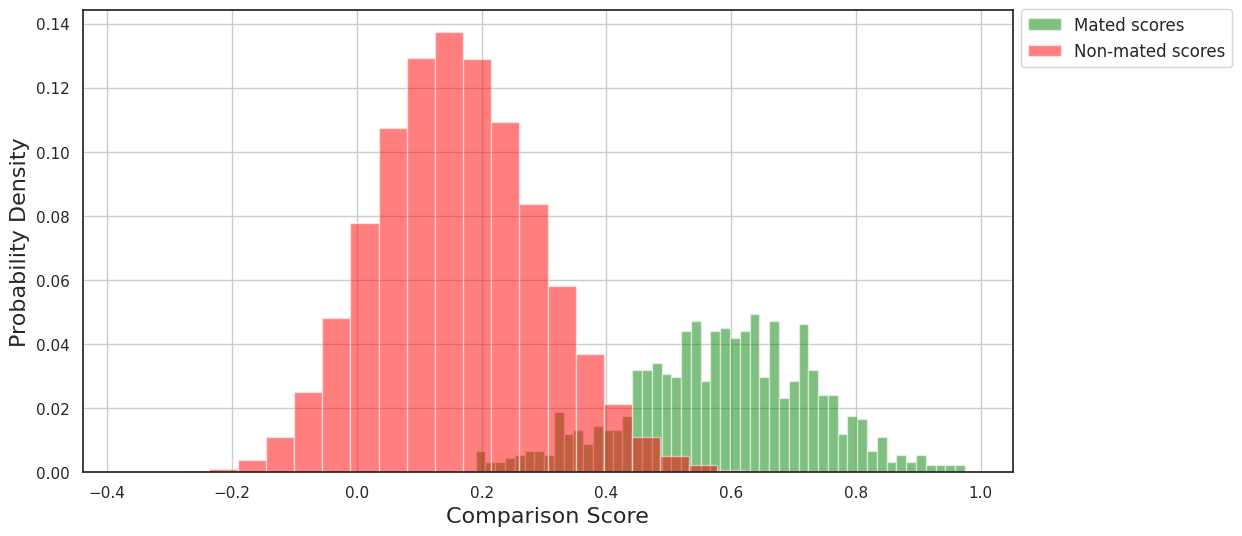

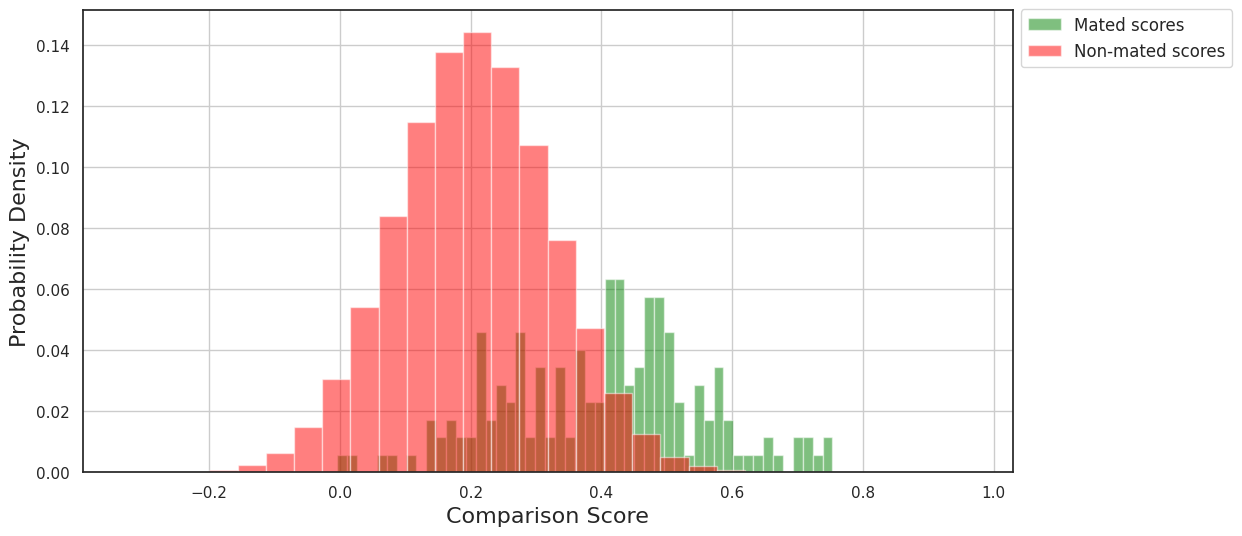

In [97]:
plot_histogram(mated_scores1, nonmated_scores1, normalise=True)
plot_histogram(mated_scores2, nonmated_scores2, normalise=True)

In [ ]:
mated_kde, mated_pos, mated_min, mated_max = get_kde(mated_scores1)
nonmated_kde, nonmated_pos, nonmated_min, nonmated_max = get_kde(nonmated_scores1)
plt.figure(figsize=figure_size)
plt.plot(mated_pos, mated_kde(mated_pos), linewidth=linewidth, color=mated_colour, label=mated_label)
plt.plot(nonmated_pos, nonmated_kde(nonmated_pos), linewidth=linewidth, color=nonmated_colour, label=nonmated_label)
plt.xlabel("Score", size=label_fontsize)
plt.ylabel("Probability Density", size=label_fontsize)
plt.grid(True)
plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize)
plt.show()

In [ ]:
mated_kde, mated_pos, mated_min, mated_max = get_kde(mated_scores2)
nonmated_kde, nonmated_pos, nonmated_min, nonmated_max = get_kde(nonmated_scores2)
plt.figure(figsize=figure_size)
plt.plot(mated_pos, mated_kde(mated_pos), linewidth=linewidth, color=mated_colour, label=mated_label)
plt.plot(nonmated_pos, nonmated_kde(nonmated_pos), linewidth=linewidth, color=nonmated_colour, label=nonmated_label)
plt.xlabel("Score", size=label_fontsize)
plt.ylabel("Probability Density", size=label_fontsize)
plt.grid(True)
plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize)
plt.show()

In [ ]:
d_prime_system1 = d_prime(mated_scores1, nonmated_scores1)
print("d' child =", round(d_prime_system1, round_digits))

d_prime_system2 = d_prime(mated_scores2, nonmated_scores2)
print("d' adult =", round(d_prime_system2, round_digits))

In [ ]:
threshold1 = 0.36
kde_with_threshold(mated_scores1, nonmated_scores1, scores_type1, threshold1)

In [ ]:
threshold2 = 0.32
kde_with_threshold(mated_scores2, nonmated_scores2, scores_type2, threshold2)

In [ ]:
style_confusion_matrix(get_confusion_matrix(mated_scores1, nonmated_scores1, scores_type1, threshold1, mode="count"))

In [ ]:
det = DET(biometric_evaluation_type='identification', abbreviate_axes=True, plot_eer_line=True, plot_title="Children vs adults")
det.x_limits = np.array([1e-4, .5])
det.y_limits = np.array([1e-4, .5])
det.x_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.x_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.y_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.y_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.create_figure()
det.plot(tar=adjust_scores_for_DET(mated_scores1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label=system_name1)
det.plot(tar=adjust_scores_for_DET(mated_scores2, scores_type2), non=adjust_scores_for_DET(nonmated_scores2, scores_type2), label=system_name2)
det.legend_on(loc="upper right")
det.show()